In [1]:
! pip install gdown
! mkdir -p ../data
! mkdir -p ../results
! gdown https://drive.google.com/drive/folders/1hPrkHyTSUak0jnpkZZ_JloUN5eDLvO9S -O ../data --folder

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Retrieving folder contents
Processing file 1C25jsAYyQlhRwERuaDRu65bbaf-D8rhf go.obo
Processing file 1ktBxXZb5yaZ9vTVcYOWnVtY-vzos-nHi Pdam_dscript_distances.DSD1.tsv
Processing file 1pFDm7I1X6ldPpk8xkVJFKqduWQSLPCZ_ Pdam_GO_map.csv
Processing file 1mCfodknnT7x_w5XRfqpMBjOC6OFc0A-c Pdam_predictions_positive.tsv
Processing file 154e2Rfu4lh5QxzZ7Nv2OgqBe90YqOUyc SymbC1_dscript_distances.DSD1.tsv
Processing file 14xGkOjPn_7ovzpND_jEdRPIhzRqmja6a SymbC1_GO_map.csv
Processing file 13HUokZbFjrzKK99lIVmhv_dbLgV1vtTD SymbC1_predictions_positive.tsv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1C25jsAYyQlhRwERuaDRu65bbaf-D8rhf
To: /data/cb/samsl/Software/philharmonic/data/go.obo
100%|██████████████████████████████████████| 33.8M/33.8M [00:00<00:00, 67.7MB/s]
Downloading...
From (original): https://drive.google.com

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np
from tqdm.notebook import tqdm
from sklearn.cluster import SpectralClustering
import pickle as pk
from sklearn.metrics import silhouette_score, silhouette_samples
from networkx.linalg.graphmatrix import adjacency_matrix
from queue import PriorityQueue


### Parameters to Modify

In [2]:
net_name = 'Pdam' # TODO: options: 'Pdam', 'SymbC1'


BASE_DIR = '..'
DATA_DIR = f'{BASE_DIR}/data/'
OUTPUT_DIR = f'{BASE_DIR}/results/'


# POST_DSD_PARAMS:
edge_weight_thresh = 0.5
kclusts = None
random_seed = 6191998
min_clust_size = 3
max_clust_size = 100

# SPECTRAL CLUSTERING PARAMS:
init_kclusts = 500
# max_clust_size = 30 # NOTE: max_clust_size IS SET BY HOW WE ARE CLUSTERING (DETERMINING N_CLUSTERS)

### End Parameters to Modify

In [3]:

# Assuming that the data has been downloaded from the google drive link, and net_name is either 'Pdam' or 'SymbC1', these do not need to be modified
go_db_file =f"{DATA_DIR}/go.obo"

interactionFile = f'{DATA_DIR}/{net_name}_predictions_positive.tsv'
DSDfile = f'{DATA_DIR}/{net_name}_dscript_distances.DSD1.tsv' 

initial_SC_pickle_file = f"{OUTPUT_DIR}{net_name}.initSC.pkl"
cluster_size_dist_file = f"{OUTPUT_DIR}{net_name}.clust_size_dist.png"
final_clusters_output_file = f"{OUTPUT_DIR}{net_name}.clusters.csv"

print(f"final clusters will be saved to {final_clusters_output_file}")

final clusters will be saved to ../results/Pdam.clusters.csv


## Initial Network Loading:

Reading DSD File...
Selecting DSD connected component...
Filtering edges with confidence threshold 0.5...


  0%|          | 0/229984 [00:00<?, ?it/s]

                   Pdam
                       
Nodes              8513
Edges            229984
Degree (Med)       22.0
Degree (Avg)  54.031246
Sparsity       0.003173
Saving Degree Distribution Plot to:  ../results/Pdam.degree_dist.png


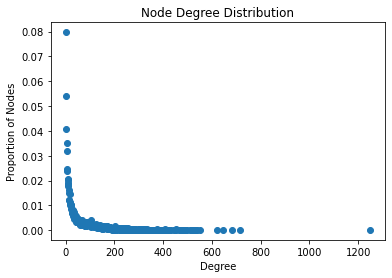

In [4]:
def display_degree_dist(G, degrees, net_name, results_dir):
    '''
    Helper function to read_network that displays the degree distribution of the initial network
    '''
    degreeDist = {}
    for i in degrees:
        n = degreeDist.setdefault(i,0)
        degreeDist[i] = n + 1

    plt.xlabel('Degree')
    plt.ylabel('Proportion of Nodes')  # we already handled the x-label with ax1
    plt.title('Node Degree Distribution')
    plt.scatter(degreeDist.keys(), [i/len(G) for i in degreeDist.values()])
    print('Saving Degree Distribution Plot to: ', results_dir + net_name + '.degree_dist.png')
    plt.savefig(results_dir + net_name + '_degree_dist.png')


def read_network(DSDfile, interactionFile, edge_weight_thresh=0.5, net_name="Network", output_stats=True, results_dir='./'):
    '''
    Read in the network and filter edges based on DSD confidence threshold
    '''
    print('Reading DSD File...')
    dsd_df = pd.read_csv(DSDfile, sep='\t', index_col=0, header=0)
    protein_names = [str(i) for i in dsd_df.index]
    DSD = dsd_df.values

    fullG = nx.read_weighted_edgelist(interactionFile)
    print('Selecting DSD connected component...')
    G = fullG.subgraph(protein_names)
    print('Filtering edges with confidence threshold {}...'.format(edge_weight_thresh))
    wG = nx.Graph()
    for (u,v,d) in tqdm(G.edges.data()):
        if d['weight'] >= edge_weight_thresh:
            wG.add_edge(u,v,weight=d['weight'])
    del G
    G = wG 
    A = nx.to_numpy_array(G, nodelist=protein_names)
    degrees = [i[1] for i in list(G.degree())]

    if output_stats:
        # print a table of network statistics
        label = ['Nodes','Edges','Degree (Med)','Degree (Avg)','Sparsity']
        value = [len(G.nodes), len(G.edges), np.median(degrees), np.mean(degrees), len(G.edges()) / len(G)**2]
        stats = pd.DataFrame([label,value]).T
        stats.columns = ['',net_name]
        stats = stats.set_index('')
        print(stats)
        # save a histogram of protein degree 
        display_degree_dist(G, degrees, net_name, results_dir)

    return G, DSD, protein_names

G, DSD, protein_names = read_network(DSDfile, interactionFile, edge_weight_thresh=edge_weight_thresh, net_name=net_name, output_stats=True, results_dir=OUTPUT_DIR)

In [5]:
def RBF(D, sigma=None):
    """
    Convert distance matrix D into similarity matrix S using Radial Basis Function (RBF) Kernel
    RBF(x,x') = exp( -((x - x')**2 / 2sigma**@))
    """
    sigma = sigma or np.sqrt(np.max(D))
    return np.exp(-1 * (np.square(D) / (2 * sigma**2))) 

print('Computing similarity scores...')
simDSD = RBF(DSD)
print('Sparsifying similarity scores...')
sparse_sim_thresh = 1e-5
simRav = simDSD.ravel()
simRav[simRav < sparse_sim_thresh] = 0
simRav = simRav.reshape(simDSD.shape)
simDSD = simRav


Computing similarity scores...
Sparsifying similarity scores...


## Perform Spectral Clustering

In [6]:

print(f'Fitting {init_kclusts} spectral clusters...')
SC = SpectralClustering(n_clusters=init_kclusts, assign_labels="discretize", random_state=random_seed, affinity='precomputed')
SC.fit(simDSD)

with open(initial_SC_pickle_file,'wb') as f:
    print('Saving initial spectral clustering to: ', initial_SC_pickle_file)
    pk.dump(SC, f)

Fitting 500 spectral clusters...


/data/cb/samsl/mambaforge/envs/dsplat/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Saving initial spectral clustering to:  ../results/Pdam.initSC.pkl


In [7]:

def print_silhouette_stats(simDSD, SC): 
    print('Silhouette Score: ', silhouette_score(simDSD,SC.labels_))
    AM = (adjacency_matrix(G).todense() != 0).astype(int)
    print('Adjacency Martrix Silhouette Score: ', silhouette_score(AM,SC.labels_)) # TODO: IDK WHAT THIS IS

print_silhouette_stats(simDSD, SC)

Silhouette Score:  -0.6379410157605779
Adjacency Martrix Silhouette Score:  -0.3383122631204542


In [8]:
with open(initial_SC_pickle_file,'rb') as f:
    print('Loading initial spectral clustering from: ', initial_SC_pickle_file)
    SC = pk.load(f)

clusteringToUse = SC
simMatrix = simDSD

clusts = [[j for j in range(len(clusteringToUse.labels_)) if clusteringToUse.labels_[j] == i] for i in range(max(clusteringToUse.labels_)+1) if i in clusteringToUse.labels_]
clusts.sort(key = lambda x: len(x), reverse=True)

Loading initial spectral clustering from:  ../results/Pdam.initSC.pkl


### Perform Further Clustering on large clusters

In [9]:
def extract_clusters(SC: SpectralClustering, og_clust:list, og_csize:int, verbosity=0): # TODO: convert Verbosity to logging (options for verbosity are 0, 1, 2)
    subCs = []
    for label in set(SC.labels_): # go through all labels
        # make a list of all nodes in the cluster assigned to given label
        subCs.append([og_clust[i] for i in range(og_csize) if SC.labels_[i] == label])
    
    if verbosity > 0:
        to_print = f"Cluster of size {og_csize} -> split into {len(subCs)} clusters "
        
        if verbosity > 1:
            to_print += "of sizes: "
            for subC in subCs:
                to_print += f"{len(subC)}/"        
        print(to_print[:-1])

    # return list of tuples of priority of cluster and list of nodes in cluster
    return [(1/len(subC), subC) for subC in subCs]

In [10]:
print(f'Initial Clustering: {len(clusts)} clusters')
clustQ = PriorityQueue()
for c in clusts:
    clustQ.put((1/len(c), c))
    
print('Splitting large clusters (>{})...'.format(max_clust_size))
while True:
    priority, c = clustQ.get()
    csize = int(1/priority)

    n_clusters = int(np.round(csize / 20)) # NOTE: this changed so that we are left with clusters of max size 30

    if n_clusters < 2:
        clustQ.put((priority, c))
        break
  
    SC2 = SpectralClustering(n_clusters=n_clusters, assign_labels="discretize", random_state=random_seed, affinity='precomputed')
    SC2.fit(simMatrix[c,:][:,c])
    
    subClusts = extract_clusters(SC2, c, csize, verbosity=2)
    for subClust in subClusts:
        clustQ.put(subClust)


print(f'Removing small clusters (<{min_clust_size})...')
filteredClusters = []
while not clustQ.empty():
    wght, c = clustQ.get()
    filteredClusters.append(c)
filteredClusters = [i for i in filteredClusters if len(i) >= min_clust_size]
print(f'Final Clustering: {len(filteredClusters)} clusters')

Initial Clustering: 128 clusters
Splitting large clusters (>100)...
Cluster of size 3567 -> split into 176 clusters of sizes: 23/22/7/28/17/27/23/47/13/46/21/11/12/25/11/10/18/37/40/3/22/6/67/27/41/19/14/4/3/69/26/4/9/7/45/13/19/15/43/25/42/48/6/18/27/10/10/28/43/57/3/29/15/10/18/18/6/7/46/32/6/46/29/26/19/19/31/36/17/41/26/26/21/2/56/22/19/4/20/11/32/9/6/48/23/9/16/38/25/2/32/26/10/36/20/11/6/30/21/25/7/17/12/60/25/35/14/11/15/5/31/9/2/17/18/16/14/7/3/21/15/15/8/31/16/8/24/34/4/22/28/16/3/16/20/2/4/9/9/11/34/12/8/51/1/43/16/7/48/4/7/6/9/22/10/14/7/21/6/12/28/26/26/4/22/4/7/14/18/7/14/6/27/35/39/24
Cluster of size 774 -> split into 39 clusters of sizes: 35/10/15/18/35/33/6/7/7/1/1/10/2/32/45/164/10/14/46/30/8/15/6/18/7/10/11/13/18/17/19/14/24/6/18/22/10/9/8
Cluster of size 728 -> split into 36 clusters of sizes: 21/9/33/3/179/30/9/12/19/5/27/10/4/10/13/20/19/6/12/11/9/19/18/22/7/14/7/32/14/25/66/1/21/6/3/12
Cluster of size 451 -> split into 23 clusters of sizes: 38/5/16/21/29/20/9/7/5/

### Display Results of Spectral Clustering

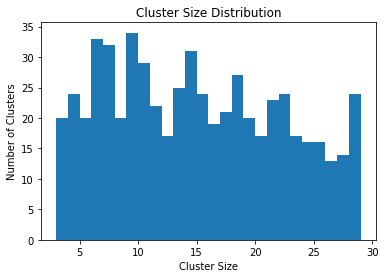

In [11]:
sizes = [len(i) for i in filteredClusters]
plt.hist(sizes, bins=range(min(sizes), max(sizes)+1))
plt.xlabel('Cluster Size')
plt.ylabel('Number of Clusters')
plt.title('Cluster Size Distribution')
plt.savefig(cluster_size_dist_file)

## Save Clusters to an Output File

In [12]:

clustsNames = [[protein_names[i] for i in cl] for cl in filteredClusters]
clustsNames.sort(key = lambda x: len(x), reverse=True)

def writeClusters(outfile, clusts):
    with open(outfile, 'w+') as f:
        for cl in clusts:
            f.write('{}\n'.format(','.join([str(i) for i in cl])))

print('Writing clusters to: ', final_clusters_output_file)
writeClusters(final_clusters_output_file, clustsNames)


Writing clusters to:  ../results/Pdam.clusters.csv


In [14]:
print('Done')

Done
